In [9]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz

--2021-06-04 15:35:30--  https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2816407858 (2.6G) [application/x-httpd-php]
Saving to: ‘HIGGS.csv.gz’

HIGGS.csv.gz        100%[===================>]   2.62G  80.3MB/s    in 45s     

2021-06-04 15:36:15 (60.3 MB/s) - ‘HIGGS.csv.gz’ saved [2816407858/2816407858]



In [10]:
!gzip -d HIGGS.csv.gz

In [11]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns

In [12]:
"""
Description:
------------
- 21 low-level features, 7 high level features
- Low-level features > kinematic properties measured by particle detectors in the accelerator.
- High-level features > Are a function of low-level features.

"""
actual_rows = 11000000  # There are 11 million Monte-carlo simulations in the dataset.
frac = 0.6  # What fraction of the whole dataset to study on?
train_frac = 0.7  # What fraction of the selected dataset to train on? Remaining used for validation.

labels_col = 0  # The index of the column corresponding to labels.
low_level_use_cols = np.arange(1, 22)  # Columns 1-21 are low level features.

train_low_level_features = pd.read_csv("HIGGS.csv", header=None, nrows=int(actual_rows*frac*train_frac), usecols=low_level_use_cols)
valid_low_level_features = pd.read_csv("HIGGS.csv", header=None, nrows=int(actual_rows*frac*(1-train_frac)), usecols=low_level_use_cols)

low_level_labels = pd.read_csv("HIGGS.csv", header=None, nrows=actual_rows*frac*train_frac, usecols=[labels_col])

train_low_level_data = pd.concat([train_low_level_features, low_level_labels], axis=1)
valid_low_level_data = pd.concat([valid_low_level_features, low_level_labels], axis=1)

Check Out: https://towardsdatascience.com/%EF%B8%8F-load-the-same-csv-file-10x-times-faster-and-with-10x-less-memory-%EF%B8%8F-e93b485086c7

Rename column names for clarity.

In [13]:
col_names = "label, lepton pT, lepton eta, lepton phi, missing energy magnitude, missing energy phi, jet 1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag, jet 2 pt, jet 2 eta, jet 2 phi, jet 2 b-tag, jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag, jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag, m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb"
cols = col_names.split(",")
cols = list(map(lambda name: name.strip(), cols))

train_low_level_data.columns = ["label"] + cols[1:22]
valid_low_level_data.columns = ["label"] + cols[1:22]

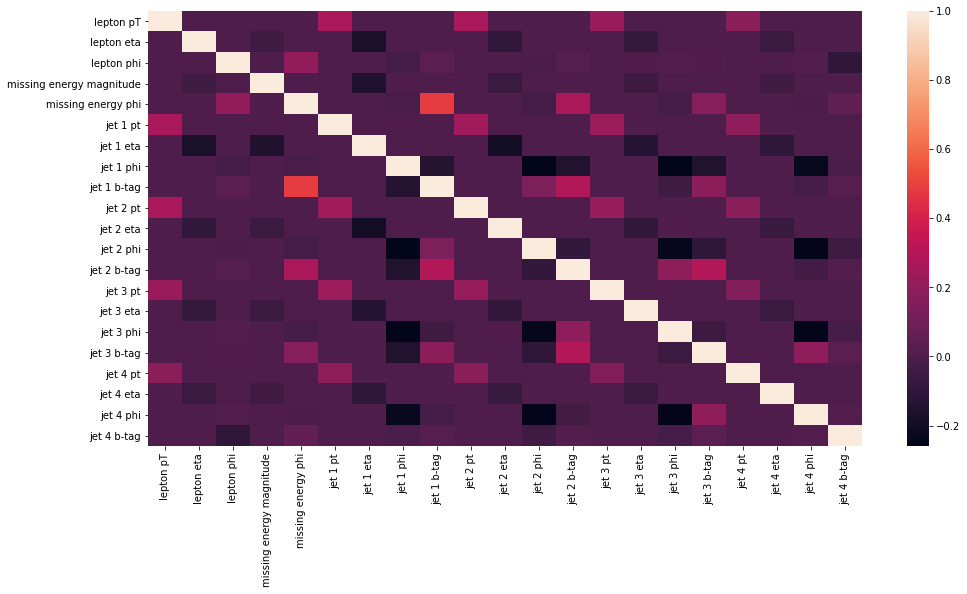

In [14]:
plt.figure(figsize=(16, 8))
corr_ = train_low_level_data.drop(["label"], axis=1).corr()
sns.heatmap(corr_)

There doesn't seem to be much correlation between these low-level features (an expected result).

Training on low-level features

In [15]:
device = torch.device('cuda:0') if torch.cuda.is_available() else 'cpu'

In [16]:
# Define a custom dataset for arranging data. 
class HIGGSDataset(Dataset):
  def __init__(self, df, root):
    self.data = df
    self.root = root

  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()  # Converts a torch tensor to a python list
    if torch.is_tensor(self.data):
      self.data = pd.DataFrame(self.data.numpy())
      class_0_1 = self.data.iloc[idx, 0]  # 0 for non-reduced csv file, 1 for reduced one. Change this to be dynamic
      values = self.data.iloc[idx, 1:]
    else:
      class_0_1 = self.data.iloc[idx, 0]
      values = self.data.iloc[idx, 1:]
    data = np.array(values)
    # data = data.astype("float").reshape(-1, 2)
    sample = {"class": class_0_1, "data": data}

    return sample

In [17]:
# Instantiating dataset
root = "/content"
train_higgs_dataset = HIGGSDataset(torch.FloatTensor(train_low_level_data.to_numpy()), root) # Using '/content/' for Google Colab
valid_higgs_dataset = HIGGSDataset(torch.FloatTensor(valid_low_level_data.to_numpy()), root)

batch_size = 32
train_loader = DataLoader(train_higgs_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_higgs_dataset, batch_size=1)

In [18]:
"""
Code trials
-----------
# Higgs_dataset = torch.utils.data.TensorDataset(Higgs_dataset)

# train_frac = 0.8
# train_length = int(len(Higgs_dataset) * train_frac)
# valid_length = int(len(Higgs_dataset) * (1 - train_frac))
# train_low_level, valid_low_level = torch.utils.data.random_split(Higgs_dataset, [train_length, valid_length])

"""

'\nCode trials\n-----------\n# Higgs_dataset = torch.utils.data.TensorDataset(Higgs_dataset)\n\n# train_frac = 0.8\n# train_length = int(len(Higgs_dataset) * train_frac)\n# valid_length = int(len(Higgs_dataset) * (1 - train_frac))\n# train_low_level, valid_low_level = torch.utils.data.random_split(Higgs_dataset, [train_length, valid_length])\n\n'

In [19]:
# batch_size = 32 # No. of samples to load per batch
# shuffle = True # Shuffle to remove any bias in data
# dataset_size = len(Higgs_dataset)
# val_split = 0.2
# split = int(np.floor(val_split * dataset_size))
# indices = list(range(dataset_size))
# np.random.shuffle(indices)

# # Split into train and valid sets
# train_indices, valid_indices = indices[split:], indices[:split]

# train_sampler = SubsetRandomSampler(train_indices)
# valid_sampler = SubsetRandomSampler(valid_indices)

# train_loader = DataLoader(Higgs_dataset, batch_size=batch_size, sampler=train_sampler)
# validation_loader = DataLoader(Higgs_dataset, batch_size=batch_size, sampler=valid_sampler)

In [20]:
class Higgs_Model(nn.Module):
  """Linear Layer Network."""
  def __init__(self, num_input_features):
    super(Higgs_Model, self).__init__()

    self.num_input_features = num_input_features

    self.fc1 = nn.Linear(num_input_features, 32)
    self.fc2 = nn.Linear(32, 64)
    self.fc3 = nn.Linear(64, 32)
    self.fc4 = nn.Linear(32, 16)
    self.fc5 = nn.Linear(16, 1)
    self.dropout = nn.Dropout(0.25)

  def forward(self, x):
    x = x.squeeze()
    x = self.dropout(x)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    x = F.relu(self.fc3(x))
    x = self.dropout(x)
    x = F.relu(self.fc4(x))
    x = self.fc5(x)
    return x

In [21]:
Higgs_model = Higgs_Model(21) # 21 kinematic features
# Higgs_model.to(device)

In [22]:
criterion = nn.BCEWithLogitsLoss()  # Using `BCEWithLogitsLoss` we can get rid of Sigmoid layer at the end of the network.
optimizer = optim.Adam(params=Higgs_model.parameters(), lr=0.0001)

In [23]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [24]:
"""
LOGS:
-----

Took slightly more than 3hrs to train 10 epochs. Output is flushed out for this cell.
Accuracy after 10 epochs was ~61%. Started with ~51% or ~57% after the first epoch.

`HIGGS_MODEL.pt` contains the saved model trained for 10 epochs which can be loaded using:

```
PATH = "/content/HIGGS_MODEL.pt"
Higgs_model.load_state_dict(torch.load(PATH))
```

where `Higgs_model` needs to be instantiated as done above

"""

EPOCHS=20

Higgs_model.train()
for e in range(1, EPOCHS+1):
  epoch_loss = 0
  epoch_acc = 0
  for i, batch in enumerate(train_loader, 0):
    data = batch['data']
    data = data.view(data.shape[0], -1)
    target = batch['class']
    target = target.type(torch.LongTensor)
    
    optimizer.zero_grad()
    
    y_pred = Higgs_model(data)
    
    loss = criterion(y_pred, target.float().unsqueeze(1))
    acc = binary_acc(y_pred, target.float().unsqueeze(1))
    
    loss.backward()
    optimizer.step()
    
    epoch_loss += loss.item()
    epoch_acc += acc.item()
      

  print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

KeyboardInterrupt: ignored

In [63]:
PATH = "/content/HIGGS_MODEL.pt"
torch.save(Higgs_model.state_dict(), PATH)

In [27]:
PATH = "/content/HIGGS_MODEL.pt"
Higgs_model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [28]:
y_pred_list = []
Higgs_model.eval()
with torch.no_grad():
  for i, batch in enumerate(valid_loader, 0):
    data = batch['data']
    data = data.view(data.shape[0], -1)
    y_test_pred = Higgs_model(data)
    y_test_pred = torch.sigmoid(y_test_pred)
    y_pred_tag = torch.round(y_test_pred)
    y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [56]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [52]:
y_preds = np.array(y_pred_list)[:1980000]  # All predictions from 1980000 to 4620000 are nan values!

In [ ]:
print(f"Accuracy on test set: {np.sum(y_preds == y_true[:1980000] / len(y_preds))}")

In [55]:
y_true = low_level_labels.to_numpy()
fpr, tpr, thresholds = roc_curve(y_true[:1980000], y_preds)  # Need to slice y_true for reasons mentioned above

In [57]:
print(f"AUC score: {roc_auc_score(y_true[:1980000], y_preds)}")

AUC score: 0.43400040914909355


Plotting ROC curve

In [61]:
!pip install plot-metric

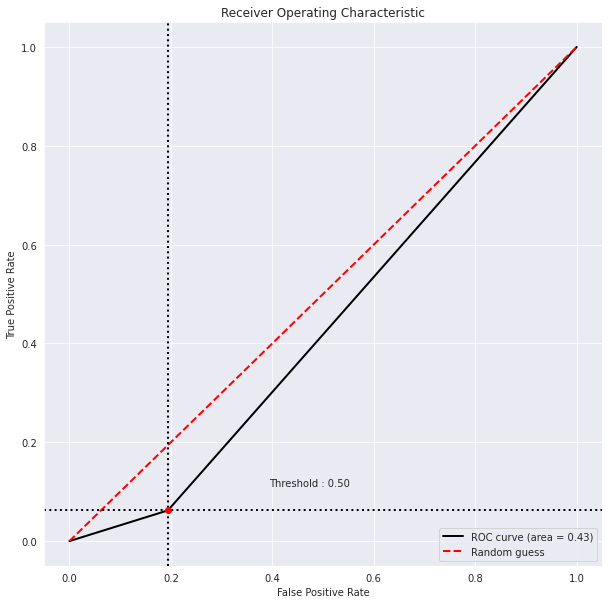

In [64]:
from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
bc = BinaryClassification(y_true[:1980000], y_preds, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(10,10))
bc.plot_roc_curve()
plt.show()

Below are some code trials kept for future reference...

In [ ]:
# # Training

# n_epochs = 20

# train_losses = []
# train_accuracy = []
# # valid_losses = []
# # valid_loss_min = np.inf

# for epoch in range(1, n_epochs+1):
#   train_loss = 0

#   # Training
#   Higgs_model.train()
#   for i, batch in enumerate(train_loader, 0):
#     data = batch['data']
#     data = data.view(data.shape[0], -1)
#     target = batch['class']
#     target = target.type(torch.LongTensor)
#     optimizer.zero_grad()
#     data, target = data.to(device), target.to(device)
#     output = Higgs_model(data.float())
#     loss = criterion(output, target.float().unsqueeze(1))
#     loss.backward()
#     optimizer.step()

#     # predicted_class = np.where(output.cpu().detach().numpy() < 0.5, 0, 1)
#     # accuracy = np.sum(target.reshape(-1, 1) == predicted_class) / len(target)
#     train_loss += loss.item()

#     if i % 2000 == 1999:
#       print(f"Epoch: {epoch}, Loss: {train_loss / 2000}")
#       train_loss = 0.0

RuntimeError: ignored

In [ ]:
# # Plot loss
# plt.style.use("seaborn")
# plt.plot(train_losses)
# plt.plot(valid_losses)
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('no.of epochs')
# plt.legend(['train', 'validation'], loc='best')
# plt.show()

In [ ]:
# # Load the model

# state_dict = torch.load('/content/higgs_model.pt')
# print(state_dict.keys())

In [ ]:
# # Create testing data
# num_test = 11000
# test_to_use = int(len(low_level_data) * 0.01)
# test_low_level_data_use = low_level_data.iloc[to_use:, :]
# test_higgs_dataset = HIGGSDataset(test_low_level_data_use, root)
# test_loader = DataLoader(test_higgs_dataset, batch_size=batch_size)

# def check_accuracy(loader, model):
#   # Reference: https://discuss.pytorch.org/t/how-to-find-test-accuracy-after-training/88962/3
#   accuracy = 0
#   num_correct = 0
#   num_samples = 0
#   model.eval()

#   preds = []
#   targets = []
  
#   with torch.no_grad():
#     for i, batch in enumerate(loader, 0):
#       data = batch['data']
#       data = data.view(data.shape[0], -1)
#       target = batch['class']
#       # x = x.to(device=device)
#       # y = y.to(device=device)
      
#       scores = model(data.float())
#       print(scores)
#       _, predictions = scores.max(1)
#       num_correct += (predictions == target).sum()
#       num_samples += predictions.size(0)
      
#       acc = float(num_correct)/float(num_samples)*100
#       print(f'Got {num_correct} / {num_samples} with accuracy {acc}') 
#       accuracy += acc
#       preds.append(predictions)
#       targets.append(target)
#   print("\n")
#   print(f"Test Accuracy: {accuracy/len(loader)}")
  
#   model.train()

#   return preds, targets

# test_higgs_model = Higgs_Model(21)
# test_higgs_model.load_state_dict(state_dict)
# preds, targets = check_accuracy(test_loader, test_higgs_model)